In [1]:
show_plots = True

In [2]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from datetime import datetime


SQLalchemy is not installed. No support for SQL output.


In [3]:
# Load the model with LoS tables from the last exercise
input_path = './../../input/'
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

In [4]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

To-Do:
- Discuss: What time period are we talking about? Only one hour or a complete day? Do we model return trips from work?
- check for number of trips per inhabitant
- should employment also be added to emission? (see page 10 quetzal 4 step presentation)
- should emissions == attractions?
- differentiate between POIs!
- make car ownership rate dependend on zone demographic data!
- make employment rate dependent on zone demographic data!
- add more categories to emission data (education etc)

#### Overview of all model params:
##### not assigned:
- demographic data
##### Exc 2:
- car_speed = bus_speed * 1.25
- walk_speed = car_speed / 3
- sm.step_road_pathfinder(all_or_nothing=True, broken_modes=False, broken_routes=False)
- sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)
##### Exc 3:
- employment_rate
- home_office_rate
- work_trips_per_day
- car_ownership
- within zone travel: 120 seconds
- preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
    )
- matching of validation: validation_buffer, threshold


In [5]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['pois'].mean() * shopping_trips_per_day * 1.8202595
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['pois'] * attraction_per_POI
print('Total emission:', int(sm.zones['emission'].sum()), \
    'Total attraction:', int(sm.zones['attraction'].sum()), \
    'Trips per person:',  round(sm.zones['emission'].sum()/sm.zones['pop'].sum(),4))

Total emission: 3630069 Total attraction: 3628602 Trips per person: 0.9615


Text(0.5, 1.0, 'attraction per zone')

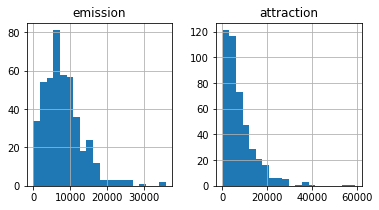

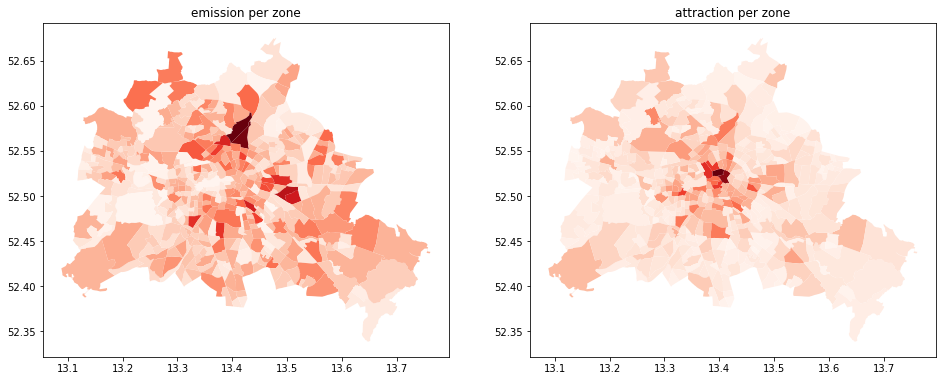

In [6]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))
fig, ax = plt.subplots(1, 2, figsize=(16,16))
sm.zones.plot(ax=ax.flat[0], column='emission', cmap="Reds")
ax.flat[0].set_title("emission per zone")
sm.zones.plot(ax=ax.flat[1], column='attraction', cmap="Reds")
ax.flat[1].set_title("attraction per zone")


In [7]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4 # To-Do: replace with demographic data
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [8]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
# sm.zones.sample()

## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

To-Do:
- check for distance travelled per inhabitant (compare to survey data)
- do we have transport data on district level or so?
- plot graphs for OD Matrix
- FRATAR algorithm, do we use it? Do we have to understand it?
- number is too small in relation to trips outside of zone. what has to be done?
- sometimes zones still have an above average connection to another zone even if its on the other side of the city. Whats the reason? What should be done?
- maybe stadtaubahn is treated as too slow in relation to other routes?

In [9]:
sm.car_los.head()

origin    destination        time  \
index                                             
0      zone_01011101  zone_01011101    0.000000   
1      zone_01011101  zone_01011102  482.752344   
2      zone_01011101  zone_01011103  274.487090   
3      zone_01011101  zone_01011104  288.127009   
4      zone_01011101  zone_01011105  297.531597   

                                                    path  \
index                                                      
0                                        [zone_01011101]   
1      [zone_01011101, 26874394, 26745299, 26874397, ...   
2      [zone_01011101, 26704698, 26704700, 26704702, ...   
3      [zone_01011101, 26704698, 26704700, 26704702, ...   
4      [zone_01011101, 26874394, 26745299, 26874397, ...   

                                               node_path  \
index                                                      
0                                                     []   
1      [26874394, 26745299, 26874397, 26703656, 26703...   
2      [26704698, 26704700, 26704702, 103553865, 2682...   
3      [26704698, 26704700, 26704702, 103553865, 2682...   
4      [26874394, 26745299, 26874397, 26703656, 26703...   

                                               link_path  \
index                                                      
0                                                     []   
1      [7686, 4937, 7690, 2681, 2675, 2678, 69015, 69...   
2      [2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...   
3      [2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...   
4      [7686, 4937, 7690, 2681, 2676, 120519, 75470, ...   

                                                  ntlegs    length  \
index                                                                
0                                                     []     0.000   
1      [[zone_01011101, 26874394], [1437259263, zone_...  1163.927   
2      [[zone_01011101, 26704698], [388310225, zone_0...  1449.637   
3      [[zone_01011101, 26704698], [26765676, zone_01...  1677.885   
4      [[zone_01011101, 26874394], [162070841, zone_0...  1724.303   

      route_types route_type     price  
index                                   
0           [car]        car  0.000000  
1           [car]        car  0.139671  
2           [car]        car  0.173956  
3           [car]        car  0.201346  
4           [car]        car  0.206916

In [10]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)
car_imp_matrix.head(3)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    120.000000    482.752344    274.487090    288.127009   
zone_01011102    498.685381    120.000000    542.488027    556.127945   
zone_01011103    300.373225    527.939158    120.000000    191.844281   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    297.531597    353.452599    426.252453    413.386755   
zone_01011102    510.762870    566.683872    584.422776    600.884807   
zone_01011103    221.970573    298.473378    381.340389    368.184042   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    451.525998    428.606507  ...   1142.668808   1221.554368   
zone_01011102    664.757271    553.647039  ...   1280.955303   1346.594900   
zone_01011103    384.981354    411.691218  ...   1197.186058   1265.437076   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101    989.320977   1315.911192   1206.818880   1077.392094   
zone_01011102   1127.607472   1454.197687   1331.859411   1215.678589   
zone_01011103   1043.838226   1370.428441   1250.701587   1131.909343   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   1076.012775   1124.849213   1008.319633   1125.101502  
zone_01011102   1214.299270   1263.135708   1146.606128   1263.387997  
zone_01011103   1130.530024   1179.366463   1062.836882   1179.618752  

[3 rows x 448 columns]

In [11]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    120.000000    782.482052    779.980010   1245.950698   
zone_01011102    782.482052    120.000000    835.858288    951.465842   
zone_01011103    779.980010    835.858288    120.000000    824.827720   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101   1100.867594   1228.593702    1228.69580   1390.194404   
zone_01011102    806.382738   1170.769312    1170.87141   1332.370014   
zone_01011103    687.284738   1210.227829    1306.75521   1389.753814   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101   1553.230589   1401.036441  ...   3031.961186   3297.768366   
zone_01011102   1495.406199   1343.212051  ...   2974.136796   3107.080094   
zone_01011103   1547.141398   1537.084938  ...   3031.520596   3390.191794   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   2738.466093   2758.930126   2869.160341   2654.066925   
zone_01011102   2547.777820   2568.241854   2678.472068   2463.378652   
zone_01011103   2830.889520   2851.353554   2961.583768   2746.490352   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   2752.642549   2963.017194   2571.453465   2754.718879  
zone_01011102   2610.454277   2820.828922   2380.765193   2564.030607  
zone_01011103   2845.065977   3055.440622   2663.876893   2847.142307  

[3 rows x 448 columns]

In [12]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

sm.volumes.head(3)

car_owner
pt_captive


origin    destination  car_owner  pt_captive       all
0  zone_01011101  zone_01011101   0.691615    0.339839  1.031454
1  zone_01011101  zone_01011102   1.179865    1.167845  2.347710
2  zone_01011101  zone_01011103   2.696178    3.625005  6.321183

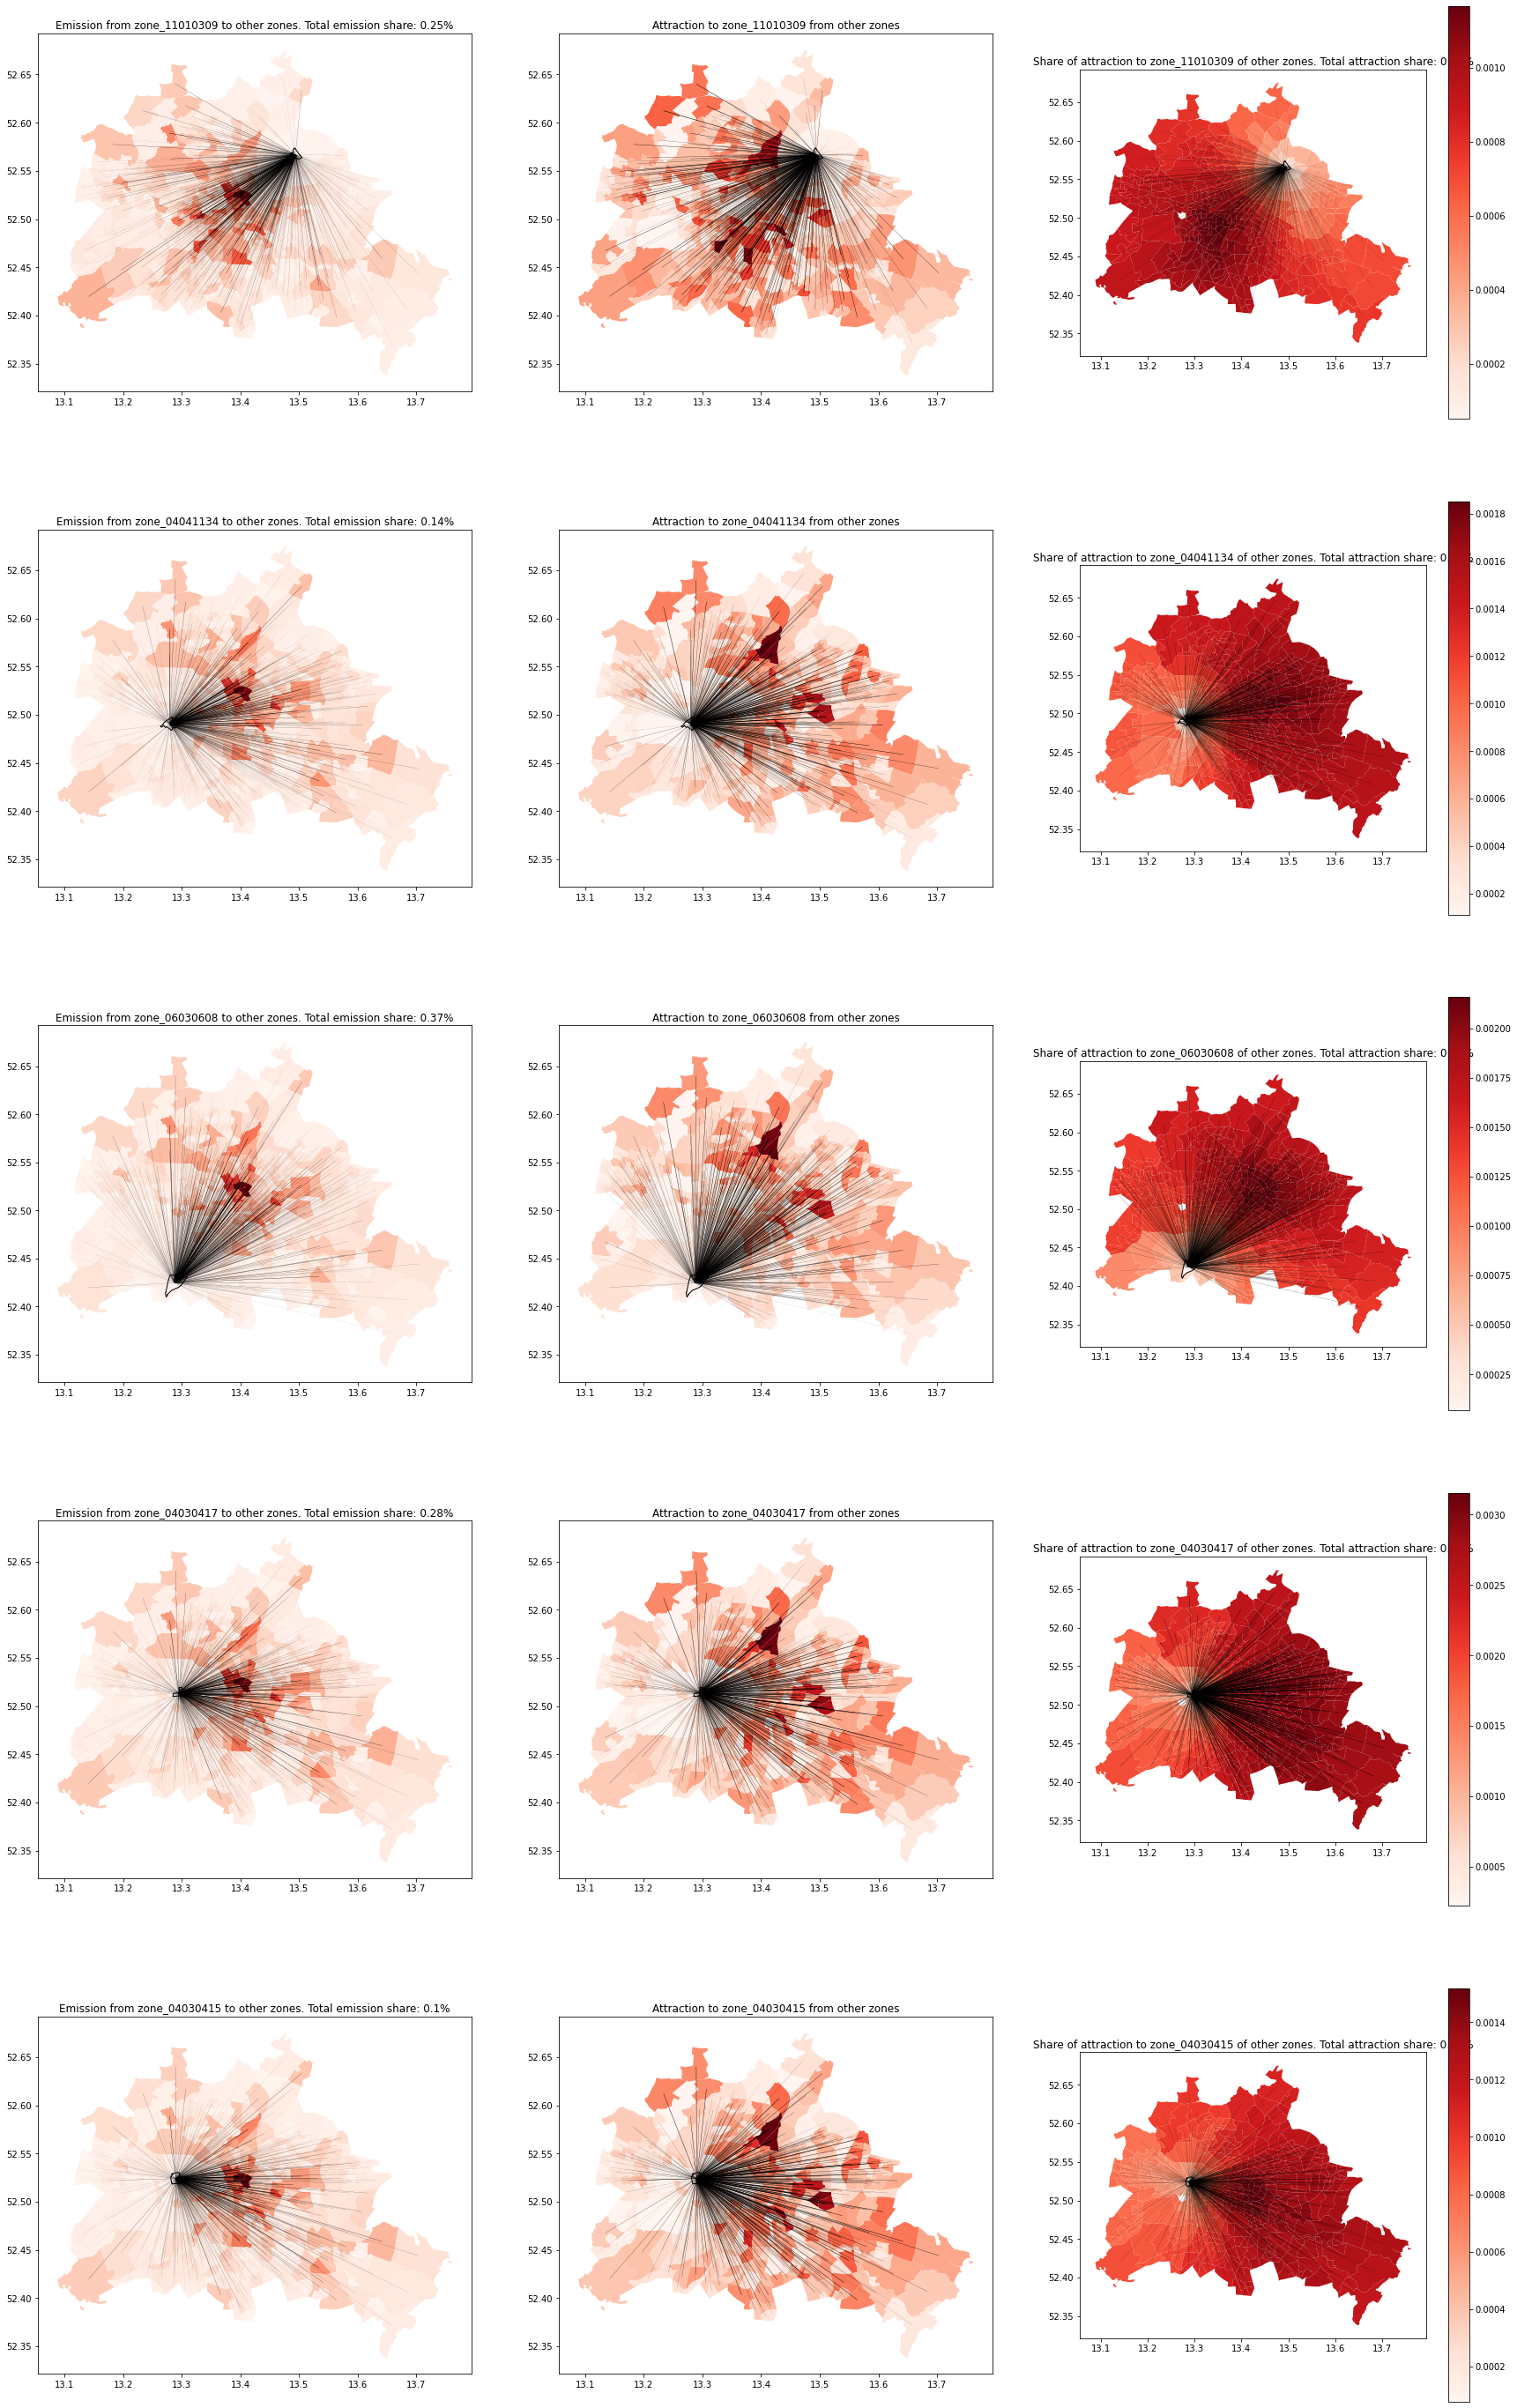

In [14]:
if show_plots:
    N = 5
    fig, ax = plt.subplots(nrows=N, ncols=3, figsize=(30,10*N))
    for (n, ind) in enumerate(np.random.permutation(len(sm.zones))[:N]):
        z_id = sm.zones.index[ind]
        
        z_emission = sm.volumes[['destination', 'all']][sm.volumes['origin']==z_id]
        z_attraction = sm.volumes[['origin', 'all']][sm.volumes['destination']==z_id]
        z_emission_from = np.array([item for sublist in [z_emission['all'][z_emission['destination']==i] for i in sm.zones.index] for item in sublist])
        z_attraction_to = np.array([item for sublist in [z_attraction['all'][z_attraction['origin']==i] for i in sm.zones.index] for item in sublist])

        all_emissions = np.array([sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        all_attractions = np.array([sum(sm.volumes['all'][sm.volumes['destination']==i]) for i in sm.zones.index])
        # z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/e for i,e in zip(sm.zones.index, all_emissions)])


        sm.zones.plot(ax=ax.flat[n*3], cmap="Reds", \
            column=z_emission_from)
        sm.zones.plot(ax=ax.flat[n*3+1], cmap="Reds", \
            column=z_attraction_to)
        sm.zones.plot(ax=ax.flat[n*3+2], cmap="Reds", \
            column=z_attraction_share, legend=True)
        

        z_centroid_coords = sm.zones['geometry'].loc[z_id].centroid.coords[0]
        lines = sm.zones.geometry.apply(lambda g: LineString([z_centroid_coords, g.centroid.centroid.coords[0]]))
        
        lines.plot(ax=ax.flat[n*3], color="black", linewidth=z_emission_from/z_emission_from.max())
        lines.plot(ax=ax.flat[n*3+1], color="black", linewidth=z_attraction_to/z_attraction_to.max())
        lines.plot(ax=ax.flat[n*3+2], color="black", linewidth=z_attraction_share/(all_attractions.max()/sum(all_attractions))*2)
        
        
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+1], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+2], color="None", edgecolor='black', linewidth=1)

        ax.flat[n*3].set_title('Emission from '+ str(z_id) + ' to other zones. Total emission share: ' + str(round(100*z_emission_from.sum()/sum(all_attractions),2)) +'%')
        ax.flat[n*3+1].set_title('Attraction to '+ str(z_id) + ' from other zones')
        ax.flat[n*3+2].set_title('Share of attraction to '+ str(z_id) + ' of other zones. Total attraction share: ' + str(round(100*z_attraction_to.sum()/sum(all_emissions),2))+'%')


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [15]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [16]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment     root car_owner pt_captive
route_type                           
rail          pt        pt         pt
car         root      root       root
root         NaN       NaN        NaN
tram          pt        pt         pt
walk        root      root       root
subway        pt        pt         pt
bus           pt        pt         pt
pt          root      root       root

In [17]:
# And the corresponding theta values
sm.logit_scales

segment     root  car_owner  pt_captive
route_type                             
rail         0.1        0.1         0.1
car          0.0        0.0         0.0
root         1.0        1.0         1.0
tram         0.1        0.1         0.1
walk         0.0        0.0         0.0
subway       0.1        0.1         0.1
bus          0.1        0.1         0.1
pt           0.5        0.5         0.5

In [18]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment     root  car_owner  pt_captive
route_type                             
rail           0          0           0
car            0          0        -100
root           0          0           0
tram           0          0           0
walk           0          0           0
subway         0          0           0
bus            0          0           0

In [19]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment          root  car_owner  pt_captive
value                                       
time         -0.00055   -0.00055    -0.00055
price        -1.00000   -1.00000    -1.00000
mode_utility  1.00000    1.00000     1.00000

In [20]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


In [21]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


In [22]:
# The result is a utilities table
sm.utilities.head(3)

route_type         origin    destination     segment      root  walk  \
0           zone_01011105  zone_01011101   car_owner -0.353287  -inf   
1           zone_01011105  zone_01011101  pt_captive -4.333743  -inf   
2           zone_01011105  zone_01011102   car_owner -0.374188  -inf   

route_type         car        pt       bus  subway  tram  rail  
0            -0.372141 -4.333743 -4.333743    -inf  -inf  -inf  
1          -100.372141 -4.333743 -4.333743    -inf  -inf  -inf  
2            -0.396375 -4.193511 -4.193511    -inf  -inf  -inf

In [23]:
# and the probabilities
sm.probabilities.head(3)

route_type         origin    destination     segment  root  walk  \
0           zone_01011105  zone_01011101   car_owner     1   0.0   
1           zone_01011105  zone_01011101  pt_captive     1   0.0   
2           zone_01011105  zone_01011102   car_owner     1   0.0   

route_type           car        pt       bus  subway  tram  rail  
0           9.813229e-01  0.018677  0.018677     0.0   0.0   0.0  
1           1.954581e-42  1.000000  1.000000     0.0   0.0   0.0  
2           9.780573e-01  0.021943  0.021943     0.0   0.0   0.0

In [24]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

origin    destination       gtime  \
0  zone_01011101  zone_01011101    0.000000   
1  zone_01011101  zone_01011102  782.482052   
2  zone_01011101  zone_01011103  779.980010   

                                    path pathfinder_session reversed  \
0                        [zone_01011101]          best_path    False   
1  [zone_01011101, n_448, zone_01011102]          best_path    False   
2  [zone_01011101, n_201, zone_01011103]          best_path    False   

  boardings alightings node_path link_path  ... access_length footpath_length  \
0        []         []        []        []  ...      0.000000             0.0   
1        []         []   [n_448]        []  ...   1068.787885             0.0   
2        []         []   [n_201]        []  ...   1071.025877             0.0   

  in_vehicle_length       length price mode_utility  (car_owner, utility)  \
0               0.0     0.000000  3.75            0             -3.750000   
1               0.0  1068.787885  3.75            0             -4.180365   
2               0.0  1071.025877  3.75            0             -4.178989   

   (pt_captive, utility)  (car_owner, probability) (pt_captive, probability)  
0              -3.750000                  0.022977                       1.0  
1              -4.180365                  0.022419                       1.0  
2              -4.178989                  0.020754                       1.0  

[3 rows x 37 columns]

## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [25]:
sm.volumes.head(2)

origin    destination  car_owner  pt_captive       all
0  zone_01011101  zone_01011101   0.691615    0.339839  1.031454
1  zone_01011101  zone_01011102   1.179865    1.167845  2.347710

In [26]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [27]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|██████████| 2/2 [00:09<00:00,  4.95s/it]


In [28]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [00:55<00:00, 27.64s/it]


In [29]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

trip_id      a      b  link_sequence  time  headway  \
index                                                                
link_2876  17311_700_3  n_283  n_579              9  60.0     1200   

            pattern_id   route_id service_id  direction_id  ... origin  \
index                                                       ...          
link_2876  17311_700_3  17311_700       1591             0  ...  n_283   

          destination                                           geometry  \
index                                                                      
link_2876       n_579  LINESTRING (13.18804 52.52241, 13.18880 52.521...   

                                              road_node_list  \
index                                                          
link_2876  [26759912, 26759910, 610214122, 28472303, 2847...   

                                              road_link_list (load, bus)  \
index                                                                      
link_2876  [5909, 5906, 56089, 14590, 14583, 5881, 5883, ...  211.658508   

          (load, subway)  (load, rail)  (load, tram)         load  
index                                                              
link_2876     397.928913   2322.838046           0.0  2932.425468  

[1 rows x 31 columns]

In [30]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

a          b   length       time   walk_time  \
index                                                         
117049  27239355  301741578  484.684  36.251306  108.753918   

                                                 geometry  highway maxspeed  \
index                                                                         
117049  LINESTRING (13.16249 52.52012, 13.15573 52.52156)  primary       50   

        (car_owner, car)  (pt_captive, car)   (all, car)  
index                                                     
117049       1694.037094       2.721799e-39  1694.037094

<AxesSubplot:>

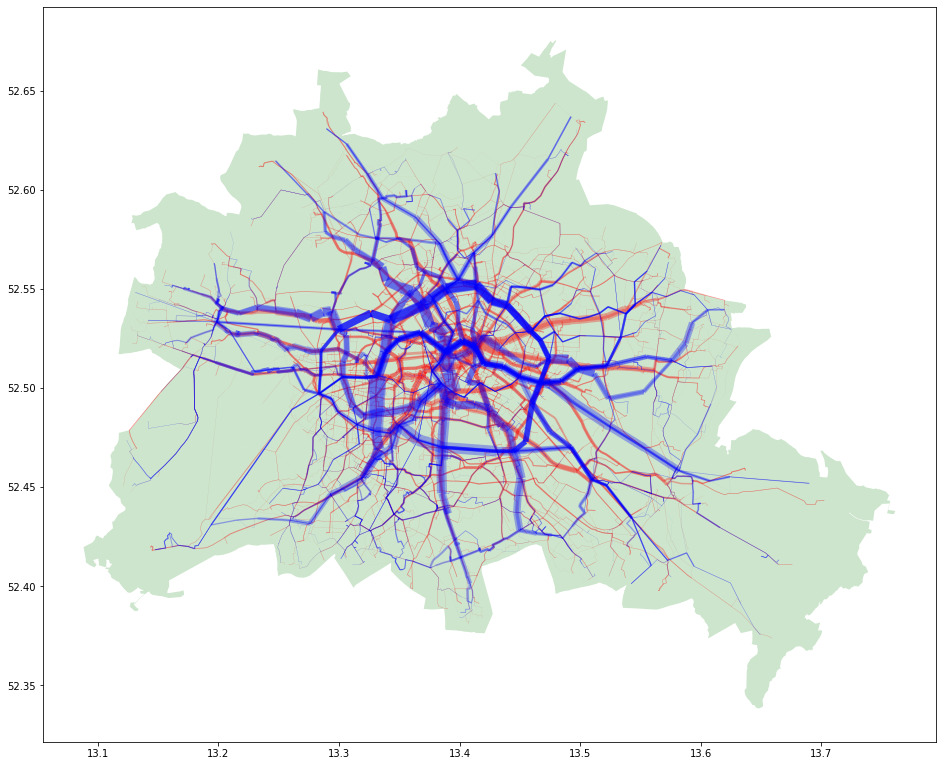

In [31]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / (35/2)

fig, ax = plt.subplots(figsize = (16,16))
sm.zones.plot(ax=ax, alpha=.2, color='green')
sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))

# sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
#     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
#         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

## Read in validation data

link_id               elem_nr         vnp         nnp  vst  \
8237  47530011_47530012  47530011_47530012.01  47530011.0  47530012.0  0.0   

        bst vricht  ebene str_typ strklasse1 strklasse strklasse2  \
8237  132.0      B    0.0       S         IV         G       STRA   

               str_name bezirk stadtteil  dtvw_kfz  dtvw_lkw  \
8237  Michaelkirchplatz  Mitte     Mitte    7900.0     170.0   

                                               geometry  
8237  LINESTRING (13.41784 52.50659, 13.41961 52.50610)

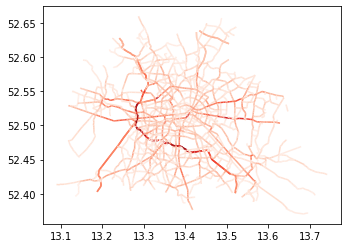

In [32]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


<AxesSubplot:>

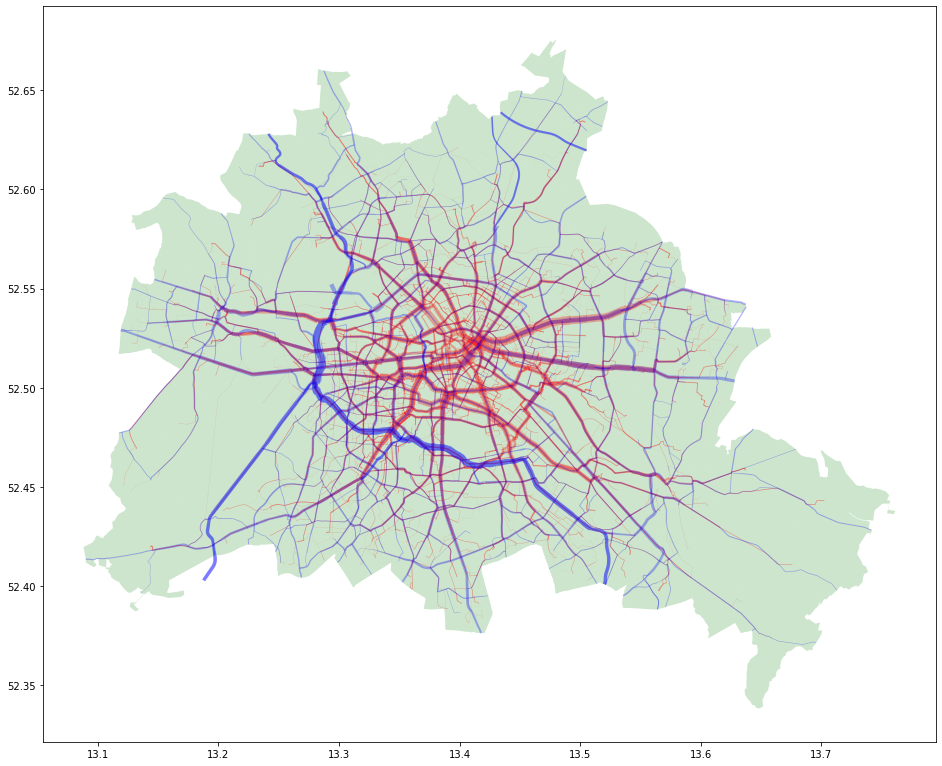

In [33]:
scaler_v = traffic_validation['dtvw_kfz'].max() / (35)


fig, ax = plt.subplots(figsize = (16,16))
sm.zones.plot(ax=ax, alpha=.2, color='green')
sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
traffic_validation.plot(ax=ax, alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/(scaler*2)))


## Match validation data to road network
- logic: create buffers around road_network and obtain intersection between the network polygons to match road links from validation data to road links from network
- for an even more accurate matching one could use the non-simplified links.

In [34]:
def gridSearchIntersections (
        intersectionOf:GeoSeries, 
        intersectionWith:GeoSeries, 
        gridDimensions:tuple=(1,1), 
        outerBox:tuple=False,
        calc_margin_on:GeoSeries=None,
        plot:bool=True
        ) -> list:
    """
    Function that speeds up the search for an array of polygon within a GeoDataFrame
    returns GeoDataFrame with original geometry replaced with intersections geometry
    
    outerBox = (min_x, min_y, max_x, max_y)
    insideBufferInMeters should be at least circle radius around if looking for intersection of circles with something
    """
    if plot: print('Generate plots.')
    print('set up margins for grid search')
    t = datetime.now()

    if not type(outerBox) == tuple:
        outerBox = intersectionWith.total_bounds
    outerBoxPoly = Polygon([(outerBox[0], outerBox[1]), (outerBox[2], outerBox[1]), (outerBox[2], outerBox[3]), (outerBox[0], outerBox[3])])
    
    # continue here maybe use intersectionWith
    if not type(calc_margin_on) in (GeoSeries, GeoDataFrame):
        calc_margin_on = intersectionOf
    if not type(calc_margin_on) == GeoDataFrame:
        calc_margin_on = GeoDataFrame(geometry=calc_margin_on, crs=calc_margin_on.crs)
    
    # prepare margin
    m_prep = [[abs(t[0]-t[1]) for t in x.xy] for x in calc_margin_on['geometry']]
    calc_margin_on['x_ext'] = [x[0] for x in m_prep]
    calc_margin_on['y_ext'] = [x[1] for x in m_prep]
    
    dim_x, dim_y = gridDimensions[0], gridDimensions[1]
    # stepsize_x, stepsize_y = (outerBox[2]-outerBox[0]-2*margin_x)/dim_x,  (outerBox[3]-outerBox[1]-2*margin_y)/dim_y
    stepsize_x, stepsize_y = (outerBox[2]-outerBox[0])/dim_x,  (outerBox[3]-outerBox[1])/dim_y

    # xsteps = [margin_x+outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    # ysteps = [margin_y+outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    xsteps = [outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    ysteps = [outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    

    print('time spent to set up correct margins', datetime.now()-t)
    print("set up grid cells")

    grid = [[] for i in range(dim_x)]
    gridPolys = []
    t = datetime.now()
    for i in range(dim_x):
        if (100 * i / dim_x) % 20 == 0 and i > 0:
            print(round(100*i/ dim_x), "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x), 
            "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x),
            'Time elapsed:', datetime.now()-t)
        
        gridCol_of = calc_margin_on.cx[xsteps[i] : xsteps[i+1], : ]
        margin_x = gridCol_of['x_ext'].max() if len(gridCol_of)>0 else 0.0

        gridCol = intersectionWith.cx[xsteps[i]-margin_x : xsteps[i+1]+margin_x, : ]
        
        if len(gridCol)==0:
            grid[i].extend([gridCol for j in range(dim_y)])
            gridPolys.extend([Polygon([]) for j in range(dim_y)])
            continue

        for j in range(dim_y):

            gridCell_of = gridCol_of.cx[ : , ysteps[j] : ysteps[j+1]]
            margin_y = gridCell_of['y_ext'].max() if len(gridCell_of)>0 else 0.0
            gridCell = gridCol.cx[ : , ysteps[j]-margin_y : ysteps[j+1]+margin_y]
            grid[i].append(gridCell) 
            
            if plot:
                gridPolys.append(Polygon([\
                    (xsteps[i]-margin_x, ysteps[j]-margin_y), \
                    (xsteps[i]-margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j]-margin_y)\
                ]))
    
    print(datetime.now() - t, "time spent to set up grid cells",gridDimensions, '=',gridDimensions[0]*gridDimensions[1], '')

    t = datetime.now()

    intersection_df = intersectionOf.copy()
    intersections = []

    time_lookup = datetime.now()-datetime.now()
    time_intersection = datetime.now()-datetime.now()

    print('start creating intersections')
    len_io = len(intersectionOf)
    for n, geom in zip(range(len_io), list(intersectionOf)):
        if (n*100 / len_io) % 2 > ((n+1)*100 / len_io) % 2 and n > 0:
            print(round(100*n/ len_io), 
            "% Time remaining:", 
            (datetime.now()-t)*(1- n/len_io)/(n/ len_io),
            'Time elapsed:', datetime.now()-t,
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)
        
        # geom = intersectionOf.iloc[n]
        t_ = datetime.now()
        centroidCoords = geom.centroid.coords[0]
        try:
            i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
        except:
            i = -1
        try:
            j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
        except:
            j = -1
        time_lookup += datetime.now()- t_

        t_ = datetime.now()
        intersection = [] if -1 in (i,j) and not geom.intersects(outerBoxPoly) else [(n,g) for n,g in zip(grid[i][j].index, grid[i][j].intersection(geom)) if not g.is_empty]
        intersection_areas = [(n, x.area) for n,x in intersection]
        intersection_union_area = unary_union([x for n,x in intersection]).area
        time_intersection += datetime.now()- t_
        intersections.append((intersection_areas, intersection_union_area))

        
    print(datetime.now() - t, "time spent to create intersection",len(intersectionOf),
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
        intersectionOf.plot(ax=ax, color="red", alpha=.3)
        intersectionWith.plot(ax=ax, color="blue", alpha=.3)
        GeoSeries([outerBoxPoly], crs=4326).plot(ax=ax, color="none", edgecolor="black", linewidth=2)
        GeoSeries(gridPolys, crs=4326).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=.5)
    
    return intersections    

### choose buffer parameter
- the coice matters! 
- be as precise as possible (its better to have fewer validation data, than wrong validation data!)


#### Match validation data to sm.road_links

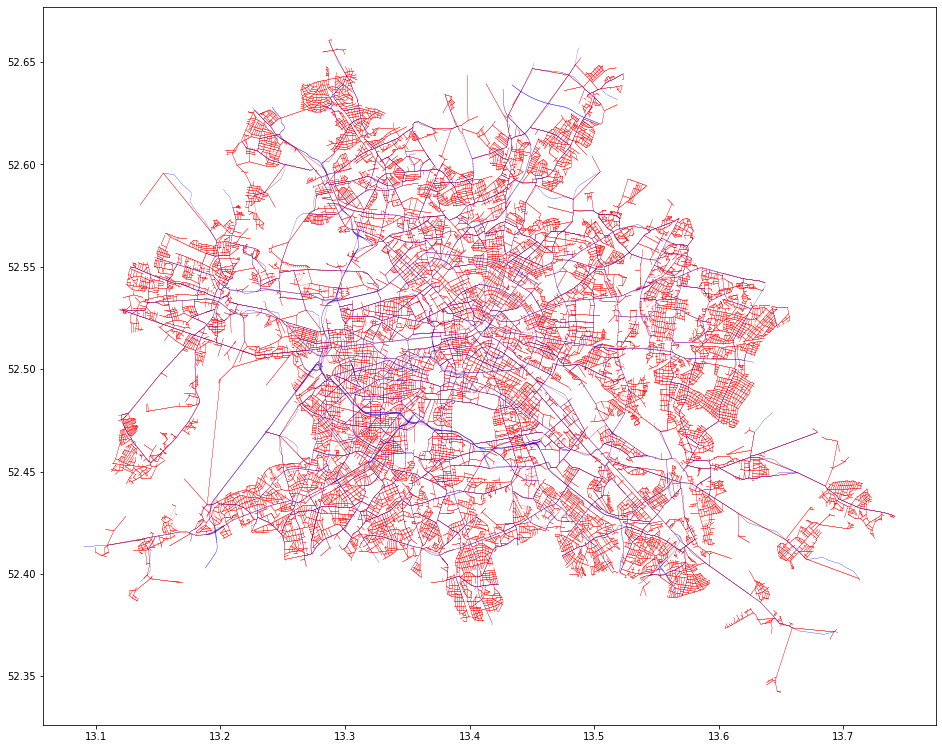

In [35]:
# define the width of each polygon. the choice of this parameter matters! b
validation_buffer = 0.0001
# for each link in road network compute its validation traffic data by:
network_buff = sm.road_links.buffer(validation_buffer*.5)
validation_buff = traffic_validation.buffer(validation_buffer)


if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    network_buff.plot(ax=ax, color="red")
    validation_buff.plot(ax=ax, color="blue", alpha=0.75)


In [36]:
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# its best to make the grid very fine so that grid creation and intersection time are balanced
# function still take over 10 Minutes.
road_links_validation_intersections = \
    gridSearchIntersections(
        intersectionOf=network_buff, 
        intersectionWith=validation_buff, 
        gridDimensions=(70,70), 
        calc_margin_on=sm.road_links['geometry'],
        plot=False
        )


set up margins for grid search
time spent to set up correct margins 0:00:12.965322
set up grid cells
20 % Time remaining: 0:01:01.929260 % Time remaining: 0:01:01.934015 Time elapsed: 0:00:15.483504
40 % Time remaining: 0:00:49.654145 % Time remaining: 0:00:49.654145 Time elapsed: 0:00:33.102763
60 % Time remaining: 0:00:33.602267 % Time remaining: 0:00:33.602267 Time elapsed: 0:00:50.403400
80 % Time remaining: 0:00:17.117882 % Time remaining: 0:00:17.117882 Time elapsed: 0:01:08.471531
0:01:22.518290 time spent to set up grid cells (70, 70) = 4900 
start creating intersections
2 % Time remaining: 0:14:32.584537 Time elapsed: 0:00:17.807311 total look_up time: 0:00:00.243422 total intersection time: 0:00:14.040285
4 % Time remaining: 0:13:22.281309 Time elapsed: 0:00:33.427359 total look_up time: 0:00:00.462634 total intersection time: 0:00:29.411149
6 % Time remaining: 0:15:37.900300 Time elapsed: 0:00:59.864095 total look_up time: 0:00:00.896610 total intersection time: 0:00:55.3495

(0.0, 1.0)

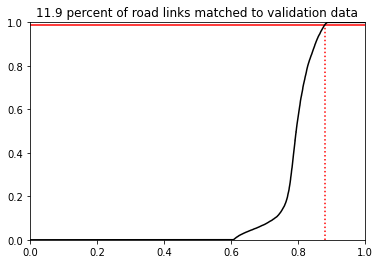

In [37]:
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# by adding a threshold of how large the  be at least
threshold = 0.99
total_intersection_areas = [sum([y for n, y in x[0]]) for x in road_links_validation_intersections]
tvd = list(traffic_validation['dtvw_kfz'])

sm.road_links['validation_load'] = \
    [sum([x/t*tvd[n] for n,x in xsections]) \
    if xarea > (nb.area * 0) else 0 \
    for (xsections, xarea),t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)] 

sm.road_links['validation_threshold'] = [xarea > (nb.area * threshold) for (xsections, xarea), nb in zip(road_links_validation_intersections, network_buff)] 

share = sum(sm.road_links['validation_threshold'])/len(sm.road_links)


plt.plot([x/len(sm.road_links) for x in range(len(sm.road_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5, 1.0, 'road links (blue) with matching of validation data (red)')

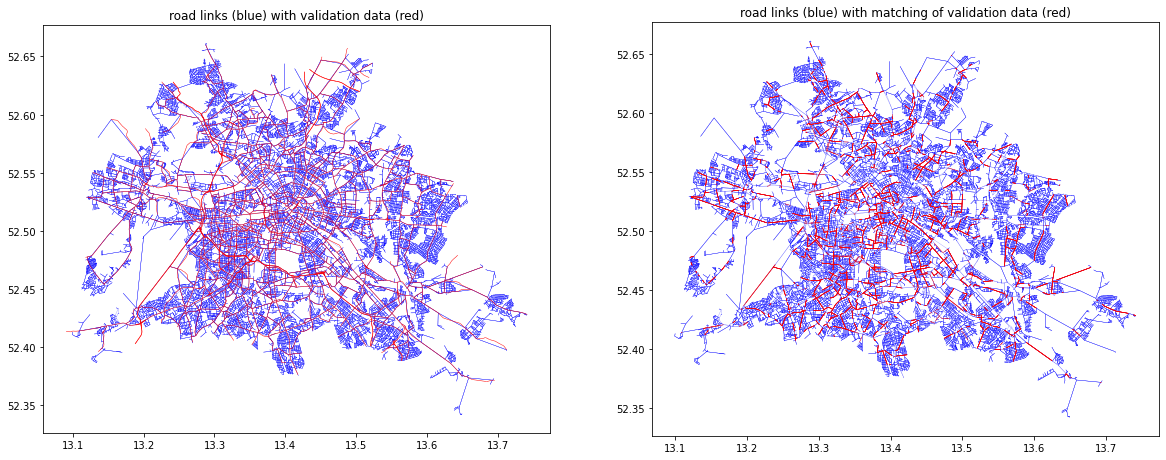

In [38]:
fig, ax = plt.subplots(ncols=2, figsize = (20,16))

sm.road_links.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=.3)
traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
ax.flat[0].set_title('road links (blue) with validation data (red)')

sm.road_links.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=.3)
sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# network_buff[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
ax.flat[1].set_title('road links (blue) with matching of validation data (red)')



network: 46657010.16954705 validation: 219503778.1968649 ratio n/v: 0.213


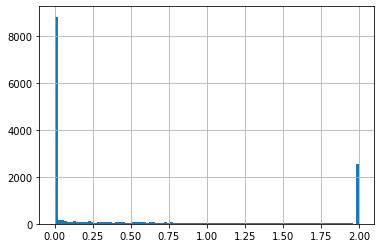

In [39]:
total_load_network = sum(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']])
total_load_validation = sum(sm.road_links['validation_load'][sm.road_links['validation_threshold']])
print('network:', total_load_network, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network/total_load_validation,3))

r_gdf = GeoDataFrame({
    'ratio': total_load_validation/total_load_network * sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] / sm.road_links['validation_load'][sm.road_links['validation_threshold']]
    }, geometry=sm.road_links['geometry'][sm.road_links['validation_threshold']], crs=sm.epsg)

# ax0 = r_gdf['ratio'].hist(bins=100)
r_gdf['ratio_cut']=[x if x<2 else 2 for x in r_gdf['ratio']]
ax1 = r_gdf['ratio_cut'].hist(bins=100)


Text(0.5, 1.0, 'Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic')

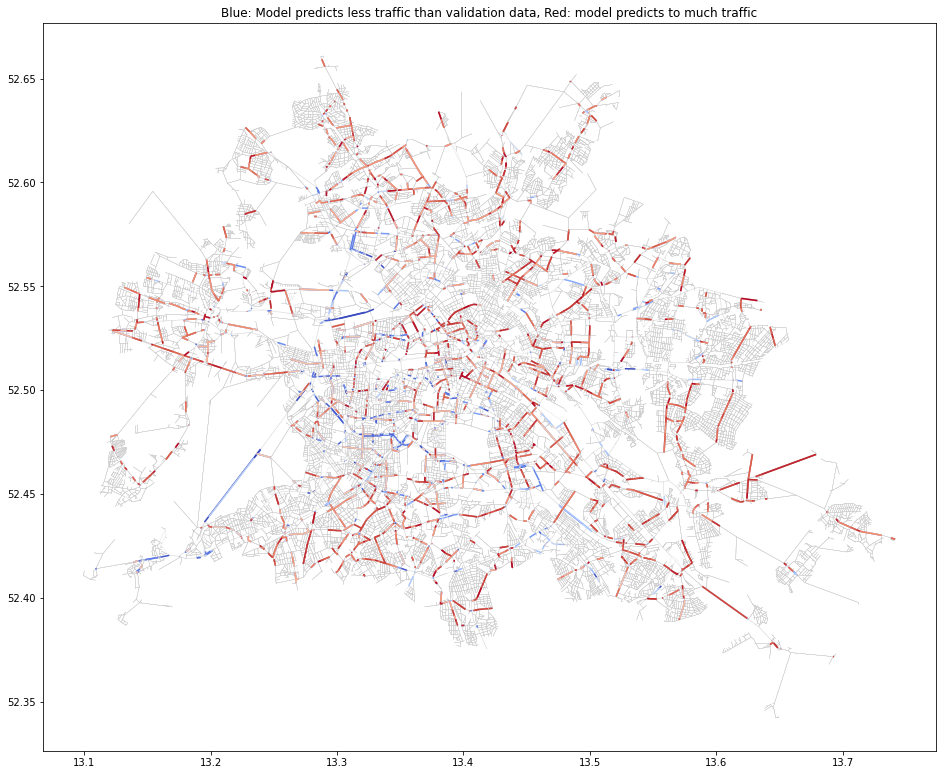

In [40]:
fig, ax = plt.subplots(figsize = (16,16))
sm.road_links.plot(ax=ax, color="#cccccc", linewidth=0.25)
r_gdf.plot(ax=ax, cmap='coolwarm', legend=True)
ax.set_title("Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic")

#### Match validation data to sm.loaded_links

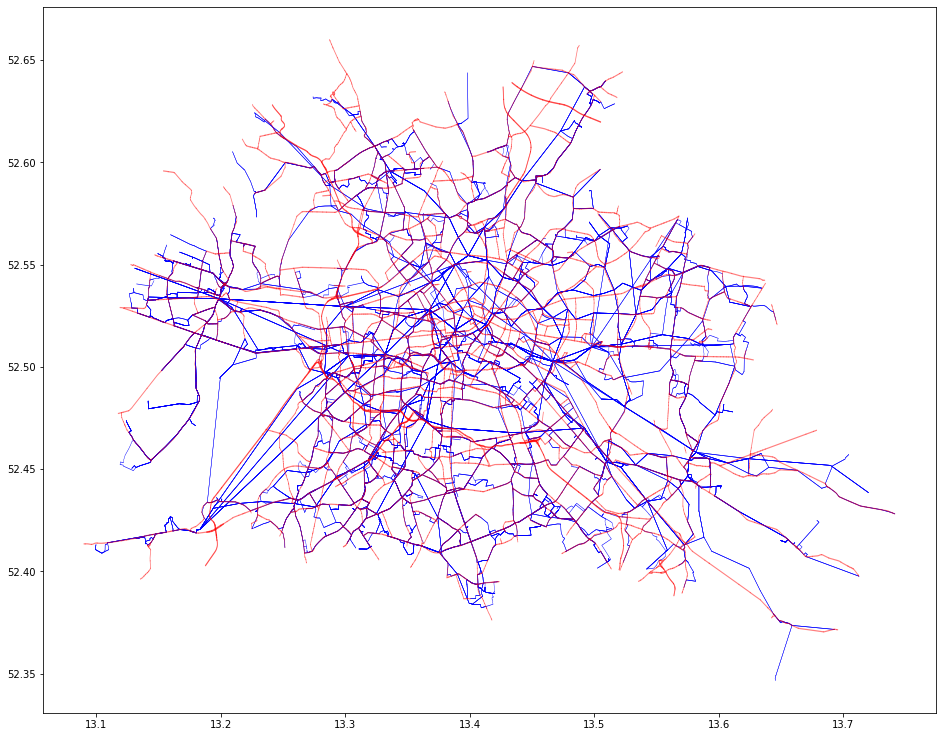

In [41]:
validation_buffer = 0.0003
# for each link in road network compute its validation traffic data by:
network_buff = sm.loaded_links.buffer(validation_buffer*.5)
validation_buff = traffic_validation.buffer(validation_buffer)

if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    network_buff.plot(ax=ax, color="blue")
    validation_buff.plot(ax=ax, color="red", alpha=0.5)


In [42]:
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# its best to make the grid very fine so that grid creation and intersection time are balanced
# function still take over 10 Minutes.
loaded_links_validation_intersections = \
    gridSearchIntersections(
        intersectionOf=network_buff, 
        intersectionWith=validation_buff, 
        gridDimensions=(50,50), 
        calc_margin_on=sm.loaded_links['geometry'],
        plot=False
        )


set up margins for grid search
time spent to set up correct margins 0:00:01.786901
set up grid cells
20 % Time remaining: 0:00:42.644610 % Time remaining: 0:00:42.648610 Time elapsed: 0:00:10.662153
40 % Time remaining: 0:00:33.799122 % Time remaining: 0:00:33.799122 Time elapsed: 0:00:22.532749
60 % Time remaining: 0:00:21.525648 % Time remaining: 0:00:21.525648 Time elapsed: 0:00:32.288473
80 % Time remaining: 0:00:10.820620 % Time remaining: 0:00:10.820620 Time elapsed: 0:00:43.282478
0:00:50.948378 time spent to set up grid cells (50, 50) = 2500 
start creating intersections
2 % Time remaining: 0:09:38.284463 Time elapsed: 0:00:11.752939 total look_up time: 0:00:00.009993 total intersection time: 0:00:11.480277
4 % Time remaining: 0:09:03.562971 Time elapsed: 0:00:22.552894 total look_up time: 0:00:00.021986 total intersection time: 0:00:22.266240
6 % Time remaining: 0:08:10.676276 Time elapsed: 0:00:31.278520 total look_up time: 0:00:00.040975 total intersection time: 0:00:30.9728

(0.0, 1.0)

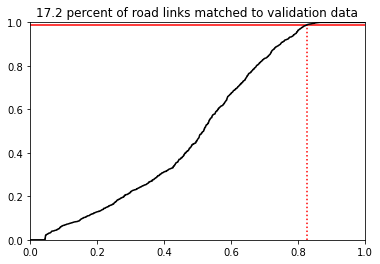

In [43]:
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# by adding a threshold of how large the  be at least
threshold = 0.99
total_intersection_areas = [sum([y for n, y in x[0]]) for x in loaded_links_validation_intersections]
tvd = list(traffic_validation['dtvw_kfz'])

sm.loaded_links['validation_load'] = \
    [sum([x/t*tvd[n] for n,x in xsections]) \
    if xarea > (nb.area * 0) else 0 \
    for (xsections, xarea),t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)] 

sm.loaded_links['validation_threshold'] = [xarea > (nb.area * threshold) for (xsections, xarea), nb in zip(loaded_links_validation_intersections, network_buff)] 

share = sum(sm.loaded_links['validation_threshold'])/len(sm.loaded_links)


plt.plot([x/len(sm.loaded_links) for x in range(len(sm.loaded_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5, 1.0, 'loaded links (blue) with matching of validation data (red)')

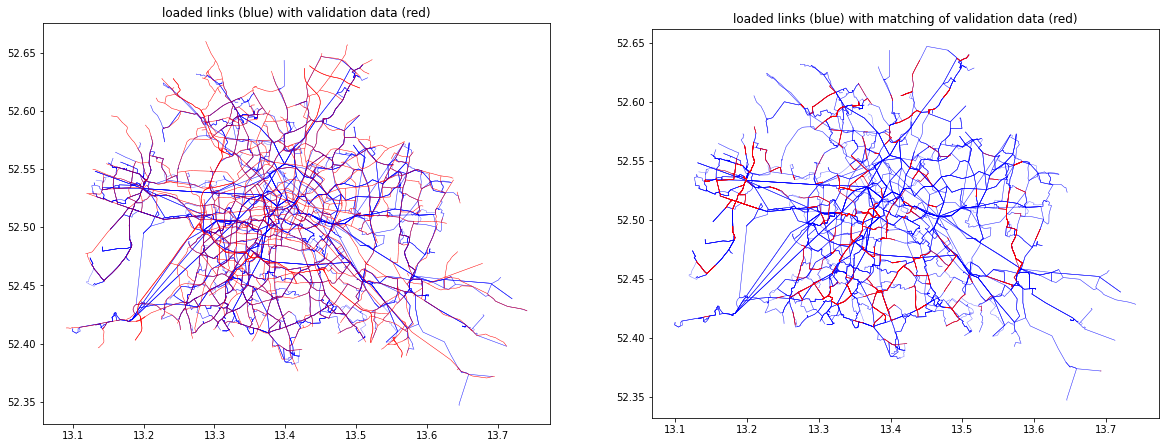

In [44]:
fig, ax = plt.subplots(ncols=2, figsize = (20,16))

sm.loaded_links.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
ax.flat[0].set_title('loaded links (blue) with validation data (red)')

sm.loaded_links.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
sm.loaded_links[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# network_buff[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
ax.flat[1].set_title('loaded links (blue) with matching of validation data (red)')



In [45]:
total_load_network_l = sum(sm.loaded_links['load'][sm.loaded_links['validation_threshold']])
total_load_validation = sum(sm.loaded_links['validation_load'][sm.loaded_links['validation_threshold']])
print('network:', total_load_network_l, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network_l/total_load_validation,3))

network: 1858968.894124489 validation: 20532590.826672085 ratio n/v: 0.091


## Model Results

In [46]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [47]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [48]:
od_sum.sample(3)

segment                          car_owner                      \
sum                                 volume     price      time   
origin        destination   mode                                 
zone_04030623 zone_12224230 car   5.390127  1.857132  0.388312   
zone_02010103 zone_02020201 bus   0.210716  0.091402  0.007474   
zone_01011402 zone_04051446 rail  0.150589  0.043859  0.005223   

segment                                                                 \
sum                              in_vehicle_time     length ntransfers   
origin        destination   mode                                         
zone_04030623 zone_12224230 car         0.000000  15.476103   0.000000   
zone_02010103 zone_02020201 bus         0.002437   0.095067   0.000000   
zone_01011402 zone_04051446 rail        0.002105   0.133865   0.017544   

segment                             pt_captive                              \
sum                                     volume         price          time   
origin        destination   mode                                             
zone_04030623 zone_12224230 car   2.227522e-41  4.491896e-42  9.392211e-43   
zone_02010103 zone_02020201 bus   1.294509e+01  3.750000e+00  3.066285e-01   
zone_01011402 zone_04051446 rail  2.639252e+01  5.000000e+00  5.954595e-01   

segment                                           ...                  root  \
sum                              in_vehicle_time  ... ntransfers     volume   
origin        destination   mode                  ...                         
zone_04030623 zone_12224230 car             0.00  ...        0.0   5.390127   
zone_02010103 zone_02020201 bus             0.10  ...        0.0  13.155809   
zone_01011402 zone_04051446 rail            0.24  ...        2.0  26.543112   

segment                                                               \
sum                                  price      time in_vehicle_time   
origin        destination   mode                                       
zone_04030623 zone_12224230 car   1.857132  0.388312        0.000000   
zone_02010103 zone_02020201 bus   3.691400  0.301837        0.098437   
zone_01011402 zone_04051446 rail  4.971882  0.592111        0.238650   

segment                                                 car_owner  \
sum                                  length ntransfers        pkm   
origin        destination   mode                                    
zone_04030623 zone_12224230 car   15.476103   0.000000  83.418159   
zone_02010103 zone_02020201 bus    3.839424   0.000000   0.020032   
zone_01011402 zone_04051446 rail  15.175075   1.988753   0.020159   

segment                             pt_captive        root  
sum                                        pkm         pkm  
origin        destination   mode                            
zone_04030623 zone_12224230 car   8.338165e-82   83.418159  
zone_02010103 zone_02020201 bus   5.049069e+01   50.510725  
zone_01011402 zone_04051446 rail  4.027736e+02  402.793711  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

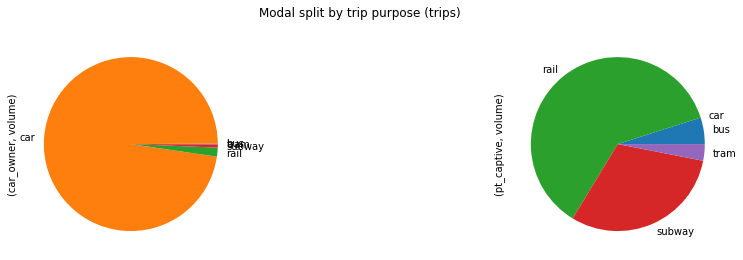

In [49]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

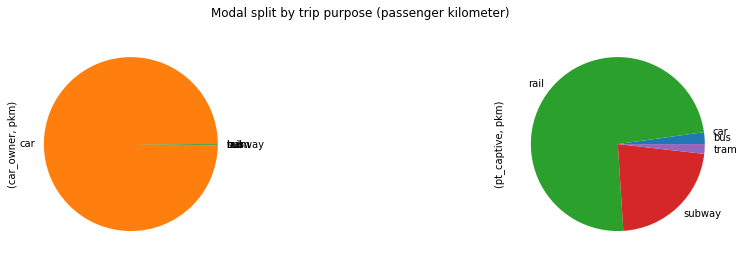

In [50]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [51]:
# Save the od_sum as Excel
if not os.path.exists('../../outputs/'):
    os.makedirs('../../outputs/')
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

In [ ]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [ ]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:19<00:20,  1.13s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [01:25<00:00,  1.90s/it]

could not save attribute: parameters
